# Linear Learner Estimator V1

### 1. Import libraries

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import boto3
import sagemaker
from sagemaker import image_uris
from sagemaker.estimator import Estimator


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


### 2. Load the dataset and understanding the data

In [2]:
# Load the dataset
df = pd.read_csv("combined_csv_v1.csv")


In [3]:
# Check rows and columns
df.shape

(1635590, 75)

In [4]:
# Check first 5 rows
df.head()

,target,Distance,Quarter_2,Quarter_3,Quarter_4,Month_2,Month_3,Month_4,Month_5,Month_6,...,Dest_DEN,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO,DepHourofDay_Evening,DepHourofDay_Morning,DepHourofDay_Night
0,0.0,689.0,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True
1,0.0,731.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,0.0,1199.0,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,True,False,False
3,0.0,1587.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,True,False,False
4,0.0,1587.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [5]:
# Check all columns type
for column in df.columns:
    print(column)


target
Distance
Quarter_2
Quarter_3
Quarter_4
Month_2
Month_3
Month_4
Month_5
Month_6
Month_7
Month_8
Month_9
Month_10
Month_11
Month_12
DayofMonth_2
DayofMonth_3
DayofMonth_4
DayofMonth_5
DayofMonth_6
DayofMonth_7
DayofMonth_8
DayofMonth_9
DayofMonth_10
DayofMonth_11
DayofMonth_12
DayofMonth_13
DayofMonth_14
DayofMonth_15
DayofMonth_16
DayofMonth_17
DayofMonth_18
DayofMonth_19
DayofMonth_20
DayofMonth_21
DayofMonth_22
DayofMonth_23
DayofMonth_24
DayofMonth_25
DayofMonth_26
DayofMonth_27
DayofMonth_28
DayofMonth_29
DayofMonth_30
DayofMonth_31
DayOfWeek_2
DayOfWeek_3
DayOfWeek_4
DayOfWeek_5
DayOfWeek_6
DayOfWeek_7
Reporting_Airline_DL
Reporting_Airline_OO
Reporting_Airline_UA
Reporting_Airline_WN
Origin_CLT
Origin_DEN
Origin_DFW
Origin_IAH
Origin_LAX
Origin_ORD
Origin_PHX
Origin_SFO
Dest_CLT
Dest_DEN
Dest_DFW
Dest_IAH
Dest_LAX
Dest_ORD
Dest_PHX
Dest_SFO
DepHourofDay_Evening
DepHourofDay_Morning
DepHourofDay_Night


In [6]:
# Convert boolean columns to 0 and 1
for col in df.columns:
    if df[col].dtype == 'bool':
        df[col] = df[col].astype(float)  # Converting True to 1 and False to 0


In [7]:
# Check all type of columns again
for column in df.columns:
    print(f"{column}: {df[column].dtype}")



target: float64
Distance: float64
Quarter_2: float64
Quarter_3: float64
Quarter_4: float64
Month_2: float64
Month_3: float64
Month_4: float64
Month_5: float64
Month_6: float64
Month_7: float64
Month_8: float64
Month_9: float64
Month_10: float64
Month_11: float64
Month_12: float64
DayofMonth_2: float64
DayofMonth_3: float64
DayofMonth_4: float64
DayofMonth_5: float64
DayofMonth_6: float64
DayofMonth_7: float64
DayofMonth_8: float64
DayofMonth_9: float64
DayofMonth_10: float64
DayofMonth_11: float64
DayofMonth_12: float64
DayofMonth_13: float64
DayofMonth_14: float64
DayofMonth_15: float64
DayofMonth_16: float64
DayofMonth_17: float64
DayofMonth_18: float64
DayofMonth_19: float64
DayofMonth_20: float64
DayofMonth_21: float64
DayofMonth_22: float64
DayofMonth_23: float64
DayofMonth_24: float64
DayofMonth_25: float64
DayofMonth_26: float64
DayofMonth_27: float64
DayofMonth_28: float64
DayofMonth_29: float64
DayofMonth_30: float64
DayofMonth_31: float64
DayOfWeek_2: float64
DayOfWeek_3: flo

### 3. Split the data into Training 70%, Validate 15% and Test 15%

In [8]:
# Split the data into Training 70%, Validate 15% and Test 15%
train, validation = train_test_split(df, test_size=0.3)
validation, test = train_test_split(validation, test_size = 0.5)

### 4. Save Train, Validate & Test to local machine for future use

In [9]:
# Save Train, Validate & Test to local machine for future use
train.to_csv("train_data.csv", index = False, header = False)
validation.to_csv("validation_data.csv", index = False, header = False)
test.to_csv("test_data.csv", index = False, header = False)

### 5. SageMaker and Boto3 Setup for Linear Learner Model

In [10]:
# Initialize a SageMaker session and create a default S3 bucket
sess = sagemaker.Session()
bucket = sess.default_bucket()

# Set the AWS region for SageMaker
region = boto3.Session().region_name

# Retrieve the container image URI for the Linear Learner algorithm in the specified region
linear_learner_container = image_uris.retrieve("linear-learner", region)

### 6. Uploading Training, Validation, and Test Data to S3


In [11]:
# Define the S3 prefix (path) for storing data related to this project
prefix = "oncloud_flights_delay/lle-v1"

# Upload training data to S3, specifying the file path and the S3 location
train_path = sess.upload_data(path="train_data.csv", key_prefix=prefix + "/input/training")

# Upload validation data to S3, specifying the file path and the S3 location
valid_path = sess.upload_data(path="validation_data.csv", key_prefix=prefix + "/input/validation")

# Upload test data to S3, specifying the file path and the S3 location
test_path = sess.upload_data(path="test_data.csv", key_prefix=prefix + "/input/test")


### 7. Configuring the Linear Learner Estimator for Binary Classification


In [12]:
# Initialize the Linear Learner Estimator with specified parameters
linear_estimator = Estimator(
    linear_learner_container,                    # URI of the Linear Learner container image
    role=sagemaker.get_execution_role(),         # AWS IAM role with necessary SageMaker permissions
    instance_count=1,                            # Number of instances to use (1 for single-machine training)
    instance_type='ml.c5.4xlarge',               # Instance type; optimized for training performance
    output_path='s3://{}/{}/output'.format(bucket, prefix)  # S3 path to store model output artifacts
)

# Set hyperparameters for the Linear Learner model
# - predictor_type='binary_classifier': Configure the model for binary classification
# - mini_batch_size=500: Batch size for each iteration; set to 500 for efficient processing of a large dataset
linear_estimator.set_hyperparameters(predictor_type='binary_classifier', mini_batch_size=500)


### 8. Defining Data Channels for Training and Validation


In [13]:
# Set up the training data channel
# Specifies the S3 path for training data and defines its content type as CSV
training_data_channel = sagemaker.TrainingInput(s3_data=train_path, content_type='text/csv')

# Set up the validation data channel
# Specifies the S3 path for validation data and defines its content type as CSV
validation_data_channel = sagemaker.TrainingInput(s3_data=valid_path, content_type='text/csv')


### 9. Training the Linear Learner Model


In [14]:
# Start the training job for the Linear Learner model
# Specifies the data channels for both training and validation data
linear_estimator.fit({'train': training_data_channel, 'validation': validation_data_channel})


INFO:sagemaker:Creating training-job with name: linear-learner-2024-11-04-07-11-34-050


2024-11-04 07:11:35 Starting - Starting the training job...
2024-11-04 07:11:50 Starting - Preparing the instances for training...
2024-11-04 07:12:15 Downloading - Downloading input data...
2024-11-04 07:12:40 Downloading - Downloading the training image...
2024-11-04 07:13:36 Training - Training image download completed. Training in progress.....Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/04/2024 07:14:04 INFO 139799813027648] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss': '

### 10. Configuring the Transformer for Batch Predictions


In [15]:
# Initialize a transformer object for batch inference
transformer = linear_estimator.transformer(
    instance_count=1,                       # Number of instances for batch transform (1 for single instance)
    instance_type="ml.c5.4xlarge",           # Instance type optimized for batch transform
    assemble_with="Line",                   # Combine the input and output lines into a single line in the output
    output_path=f"s3://{bucket}/{prefix}/batch_output"  # S3 path to store batch transform output
)


INFO:sagemaker:Creating model with name: linear-learner-2024-11-04-07-29-57-156


### 11. Loading Test Data and Preparing Batch Input for Prediction


In [16]:
# Load the test dataset from a CSV file
df_test = pd.read_csv('test_data.csv')

# Prepare the test batch by selecting all columns except the first one (usually the target column)
test_batch = df_test[df_test.columns[1:]]

### 12. Saving and Uploading Test Batch for Batch Transform Inference


In [17]:
# Save the test batch to a CSV file without index and header
test_batch.to_csv("batch_input_lle-v1.csv", index=False, header=False)

# Upload the saved test batch file to S3 for batch transform processing
batch_test_path = sess.upload_data(path="batch_input_lle-v1.csv", key_prefix=prefix + "/batch_input")

# Start the batch transform job using the uploaded test batch file in S3
transformer.transform(batch_test_path, content_type="text/csv", split_type="Line")

# Wait for the batch transform job to complete before proceeding
transformer.wait()

INFO:sagemaker:Creating transform job with name: linear-learner-2024-11-04-07-30-18-677


..........................................
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[11/04/2024 07:37:17 INFO 140427164952384] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:495: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cons['type'] is 'ineq':
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:743: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(self.X_min) is not 0:
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[11/04/2024 07:37:17 INFO 140427164952384] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
/opt/amazon/lib/python3.8/site-packages/mxnet/mod

In [18]:
# Check my prefix
print(prefix)

oncloud_flights_delay/lle-v1


### 13. Retrieving Batch Transform Output from S3 and Loading Predictions


In [19]:
import io

# Download the batch transform output file from S3
y_file = boto3.client("s3").get_object(Bucket=bucket, Key="oncloud_flights_delay/lle-v1/batch_output/batch_input_lle-v1.csv.out")

# Load the output data into a DataFrame, naming the column "Predicted"
y_pred = pd.read_csv(io.BytesIO(y_file["Body"].read()), header=None, names=["Predicted"])

### 14. Listing Objects in an S3 Bucket Folder


In [20]:
# Listing Objects in an S3 Bucket Folder

import boto3

# Initialize an S3 client to interact with the S3 service
s3 = boto3.client("s3")

# List all objects in the specified S3 bucket and prefix (folder path)
response = s3.list_objects_v2(Bucket=bucket, Prefix=prefix)

# Check if any objects were returned in the response under the 'Contents' key
if 'Contents' in response:
    # Loop through each object and print its key (path within the bucket)
    for obj in response['Contents']:
        print(obj['Key'])
else:
    # Print a message if no objects were found under the specified prefix
    print("No objects found in the specified prefix.")


oncloud_flights_delay/lle-v1/batch_input/batch_input_lle-v1.csv
oncloud_flights_delay/lle-v1/batch_output/batch_input_lle-v1.csv.out
oncloud_flights_delay/lle-v1/input/test/test_data.csv
oncloud_flights_delay/lle-v1/input/training/train_data.csv
oncloud_flights_delay/lle-v1/input/validation/validation_data.csv
oncloud_flights_delay/lle-v1/output/linear-learner-2024-11-04-07-06-07-901/profiler-output/system/incremental/2024110407/1730703960.algo-1.json
oncloud_flights_delay/lle-v1/output/linear-learner-2024-11-04-07-06-07-901/profiler-output/system/incremental/2024110407/1730704020.algo-1.json
oncloud_flights_delay/lle-v1/output/linear-learner-2024-11-04-07-06-07-901/profiler-output/system/incremental/2024110407/1730704080.algo-1.json
oncloud_flights_delay/lle-v1/output/linear-learner-2024-11-04-07-06-07-901/profiler-output/system/incremental/2024110407/1730704140.algo-1.json
oncloud_flights_delay/lle-v1/output/linear-learner-2024-11-04-07-06-07-901/profiler-output/system/incremental/20

In [21]:
# Add an index-based "target" column to the y_pred DataFrame
# This column will reflect the DataFrame's row index as a new column named "target"
y_pred["target"] = y_pred.index

# Display the y_pred DataFrame to check its contents
y_pred


,Predicted,target
"{""predicted_label"":0",score:0.215585201978683},"{""predicted_label"":0"
"{""predicted_label"":0",score:0.197761580348014},"{""predicted_label"":0"
"{""predicted_label"":0",score:0.212198212742805},"{""predicted_label"":0"
"{""predicted_label"":0",score:0.191298052668571},"{""predicted_label"":0"
"{""predicted_label"":0",score:0.186651512980461},"{""predicted_label"":0"
...,...,...
"{""predicted_label"":0",score:0.198610320687294},"{""predicted_label"":0"
"{""predicted_label"":0",score:0.202489987015724},"{""predicted_label"":0"
"{""predicted_label"":0",score:0.214982464909553},"{""predicted_label"":0"
"{""predicted_label"":0",score:0.20071955025196},"{""predicted_label"":0"


### 15. Calculating Accuracy, Precision, Recall and ROC


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
[[193988      0]
 [ 51350      0]]

Model Performance Metrics:
Accuracy: 0.7907
Precision: 0.0000
Recall: 0.0000
ROC AUC: 0.5000


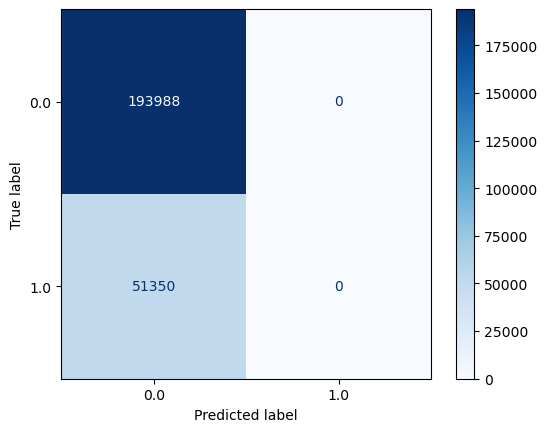

In [31]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, ConfusionMatrixDisplay

# Apply a lambda function to the "target" column to create binary predicted values
# This will set each value to 1 if it's 1, and 0 otherwise
predicted_values = y_pred['target'].apply(lambda x: 1 if x == 1 else 0)

# Extract the known labels (actual target values) from the first column of the test dataset
known_labels = df_test.iloc[:, 0]

# Calculate accuracy, precision, recall, and ROC AUC score
accuracy = accuracy_score(known_labels, predicted_values)
precision = precision_score(known_labels, predicted_values)
recall = recall_score(known_labels, predicted_values)
roc_auc = roc_auc_score(known_labels, predicted_values)

# Calculate and display the confusion matrix
conf_matrix = confusion_matrix(known_labels, predicted_values)
print("Confusion Matrix:")
print(conf_matrix)

# Print the calculated metrics
print("\nModel Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Plotting the confusion matrix with a custom color map
ConfusionMatrixDisplay.from_predictions(known_labels, predicted_values, cmap='Blues')


# Linear Learner Estimator V2

### 1. Import libraries

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import boto3
import sagemaker
from sagemaker import image_uris
from sagemaker.estimator import Estimator


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


### 2. Load the dataset and understanding the data

In [ ]:
# Load the dataset
df = pd.read_csv("combined_csv_v2.csv")


In [ ]:
# Check rows and columns
df.shape

(1635590, 86)

In [ ]:
# Check first 5 rows
df.head()

,target,Distance,DepHourofDay,AWND_O,PRCP_O,TAVG_O,AWND_D,PRCP_D,TAVG_D,SNOW_O,...,Origin_SFO,Dest_CLT,Dest_DEN,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO,is_holiday_1
0,0.0,689.0,21,33,0,54.0,30,0,130.0,0.0,...,False,False,False,False,True,False,False,False,False,False
1,0.0,731.0,9,39,0,136.0,33,0,54.0,0.0,...,False,False,False,False,False,False,False,False,False,False
2,0.0,1199.0,18,33,0,54.0,77,0,68.0,0.0,...,False,False,True,False,False,False,False,False,False,False
3,0.0,1587.0,16,33,0,54.0,20,0,165.0,0.0,...,False,False,False,False,False,False,False,True,False,False
4,0.0,1587.0,7,20,0,165.0,33,0,54.0,0.0,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
# Check all columns type
for column in df.columns:
    print(column)


target
Distance
DepHourofDay
AWND_O
PRCP_O
TAVG_O
AWND_D
PRCP_D
TAVG_D
SNOW_O
SNOW_D
Year_2015
Year_2016
Year_2017
Year_2018
Quarter_2
Quarter_3
Quarter_4
Month_2
Month_3
Month_4
Month_5
Month_6
Month_7
Month_8
Month_9
Month_10
Month_11
Month_12
DayofMonth_2
DayofMonth_3
DayofMonth_4
DayofMonth_5
DayofMonth_6
DayofMonth_7
DayofMonth_8
DayofMonth_9
DayofMonth_10
DayofMonth_11
DayofMonth_12
DayofMonth_13
DayofMonth_14
DayofMonth_15
DayofMonth_16
DayofMonth_17
DayofMonth_18
DayofMonth_19
DayofMonth_20
DayofMonth_21
DayofMonth_22
DayofMonth_23
DayofMonth_24
DayofMonth_25
DayofMonth_26
DayofMonth_27
DayofMonth_28
DayofMonth_29
DayofMonth_30
DayofMonth_31
DayOfWeek_2
DayOfWeek_3
DayOfWeek_4
DayOfWeek_5
DayOfWeek_6
DayOfWeek_7
Reporting_Airline_DL
Reporting_Airline_OO
Reporting_Airline_UA
Reporting_Airline_WN
Origin_CLT
Origin_DEN
Origin_DFW
Origin_IAH
Origin_LAX
Origin_ORD
Origin_PHX
Origin_SFO
Dest_CLT
Dest_DEN
Dest_DFW
Dest_IAH
Dest_LAX
Dest_ORD
Dest_PHX
Dest_SFO
is_holiday_1


In [ ]:
# Convert boolean columns to 0 and 1
for col in df.columns:
    if df[col].dtype == 'bool':
        df[col] = df[col].astype(float)  # Converting True to 1 and False to 0


In [ ]:
# Check all type of columns again
for column in df.columns:
    print(f"{column}: {df[column].dtype}")



target: float64
Distance: float64
DepHourofDay: int64
AWND_O: int64
PRCP_O: int64
TAVG_O: float64
AWND_D: int64
PRCP_D: int64
TAVG_D: float64
SNOW_O: float64
SNOW_D: float64
Year_2015: float64
Year_2016: float64
Year_2017: float64
Year_2018: float64
Quarter_2: float64
Quarter_3: float64
Quarter_4: float64
Month_2: float64
Month_3: float64
Month_4: float64
Month_5: float64
Month_6: float64
Month_7: float64
Month_8: float64
Month_9: float64
Month_10: float64
Month_11: float64
Month_12: float64
DayofMonth_2: float64
DayofMonth_3: float64
DayofMonth_4: float64
DayofMonth_5: float64
DayofMonth_6: float64
DayofMonth_7: float64
DayofMonth_8: float64
DayofMonth_9: float64
DayofMonth_10: float64
DayofMonth_11: float64
DayofMonth_12: float64
DayofMonth_13: float64
DayofMonth_14: float64
DayofMonth_15: float64
DayofMonth_16: float64
DayofMonth_17: float64
DayofMonth_18: float64
DayofMonth_19: float64
DayofMonth_20: float64
DayofMonth_21: float64
DayofMonth_22: float64
DayofMonth_23: float64
Dayof

### 3. Split the data into Training 70%, Validate 15% and Test 15%

In [ ]:
# Split the data into Training 70%, Validate 15% and Test 15%
train, validation = train_test_split(df, test_size=0.3)
validation, test = train_test_split(validation, test_size = 0.5)

### 4. Save Train, Validate & Test to local machine for future use

In [ ]:
# Save Train, Validate & Test to local machine for future use
train.to_csv("train_data.csv", index = False, header = False)
validation.to_csv("validation_data.csv", index = False, header = False)
test.to_csv("test_data.csv", index = False, header = False)

### 5. SageMaker and Boto3 Setup for Linear Learner Model

In [ ]:
# Initialize a SageMaker session and create a default S3 bucket
sess = sagemaker.Session()
bucket = sess.default_bucket()

# Set the AWS region for SageMaker
region = boto3.Session().region_name

# Retrieve the container image URI for the Linear Learner algorithm in the specified region
linear_learner_container = image_uris.retrieve("linear-learner", region)

### 6. Uploading Training, Validation, and Test Data to S3


In [ ]:
# Define the S3 prefix (path) for storing data related to this project
prefix = "oncloud_flights_delay/lle-v2"

# Upload training data to S3, specifying the file path and the S3 location
train_path = sess.upload_data(path="train_data.csv", key_prefix=prefix + "/input/training")

# Upload validation data to S3, specifying the file path and the S3 location
valid_path = sess.upload_data(path="validation_data.csv", key_prefix=prefix + "/input/validation")

# Upload test data to S3, specifying the file path and the S3 location
test_path = sess.upload_data(path="test_data.csv", key_prefix=prefix + "/input/test")


### 7. Configuring the Linear Learner Estimator for Binary Classification


In [ ]:
# Initialize the Linear Learner Estimator with specified parameters
linear_estimator = Estimator(
    linear_learner_container,                    # URI of the Linear Learner container image
    role=sagemaker.get_execution_role(),         # AWS IAM role with necessary SageMaker permissions
    instance_count=1,                            # Number of instances to use (1 for single-machine training)
    instance_type='ml.c5.4xlarge',               # Instance type; optimized for training performance
    output_path='s3://{}/{}/output'.format(bucket, prefix)  # S3 path to store model output artifacts
)

# Set hyperparameters for the Linear Learner model
# - predictor_type='binary_classifier': Configure the model for binary classification
# - mini_batch_size=1000: Batch size for each iteration; set to 1000 for efficient processing of a large dataset
linear_estimator.set_hyperparameters(predictor_type='binary_classifier', mini_batch_size=1000)


### 8. Defining Data Channels for Training and Validation


In [ ]:
# Set up the training data channel
# Specifies the S3 path for training data and defines its content type as CSV
training_data_channel = sagemaker.TrainingInput(s3_data=train_path, content_type='text/csv')

# Set up the validation data channel
# Specifies the S3 path for validation data and defines its content type as CSV
validation_data_channel = sagemaker.TrainingInput(s3_data=valid_path, content_type='text/csv')


### 9. Training the Linear Learner Model


In [ ]:
# Start the training job for the Linear Learner model
# Specifies the data channels for both training and validation data
linear_estimator.fit({'train': training_data_channel, 'validation': validation_data_channel})


INFO:sagemaker:Creating training-job with name: linear-learner-2024-11-04-08-00-12-487


2024-11-04 08:00:12 Starting - Starting the training job...
2024-11-04 08:00:47 Starting - Preparing the instances for training...
2024-11-04 08:01:15 Downloading - Downloading input data...
2024-11-04 08:01:45 Downloading - Downloading the training image......
2024-11-04 08:02:26 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/04/2024 08:02:53 INFO 140110271153984] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss': 

### 10. Configuring the Transformer for Batch Predictions


In [ ]:
# Initialize a transformer object for batch inference
transformer = linear_estimator.transformer(
    instance_count=1,                       # Number of instances for batch transform (1 for single instance)
    instance_type="ml.c5.4xlarge",           # Instance type optimized for batch transform
    assemble_with="Line",                   # Combine the input and output lines into a single line in the output
    output_path=f"s3://{bucket}/{prefix}/batch_output"  # S3 path to store batch transform output
)


INFO:sagemaker:Creating model with name: linear-learner-2024-11-04-08-12-38-764


### 11. Loading Test Data and Preparing Batch Input for Prediction


In [ ]:
# Load the test dataset from a CSV file
df_test = pd.read_csv('test_data.csv')

# Prepare the test batch by selecting all columns except the first one (usually the target column)
test_batch = df_test[df_test.columns[1:]]

### 12. Saving and Uploading Test Batch for Batch Transform Inference


In [ ]:
# Save the test batch to a CSV file without index and header
test_batch.to_csv("batch_input_lle-v2.csv", index=False, header=False)

# Upload the saved test batch file to S3 for batch transform processing
batch_test_path = sess.upload_data(path="batch_input_lle-v2.csv", key_prefix=prefix + "/batch_input")

# Start the batch transform job using the uploaded test batch file in S3
transformer.transform(batch_test_path, content_type="text/csv", split_type="Line")

# Wait for the batch transform job to complete before proceeding
transformer.wait()

INFO:sagemaker:Creating transform job with name: linear-learner-2024-11-04-08-14-39-519


..........................................
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[11/04/2024 08:21:42 INFO 140629389825856] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:495: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cons['type'] is 'ineq':
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:743: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(self.X_min) is not 0:
[11/04/2024 08:21:45 WARNING 140629389825856] Loggers have already been setup.
[11/04/2024 08:21:45 INFO 140629389825856] loaded entry point class algorithm.serve.server_config:config_api
[11/04/2024 08:21:45 INFO 140629389825856] loading entry points
[11/04/2024 08

In [ ]:
# Check my prefix
print(prefix)

oncloud_flights_delay/lle-v2


### 13. Retrieving Batch Transform Output from S3 and Loading Predictions


In [ ]:
import io

# Download the batch transform output file from S3
y_file = boto3.client("s3").get_object(Bucket=bucket, Key="oncloud_flights_delay/lle-v2/batch_output/batch_input_lle-v2.csv.out")

# Load the output data into a DataFrame, naming the column "Predicted"
y_pred = pd.read_csv(io.BytesIO(y_file["Body"].read()), header=None, names=["Predicted"])

### 14. Listing Objects in an S3 Bucket Folder


In [ ]:
# Listing Objects in an S3 Bucket Folder

import boto3

# Initialize an S3 client to interact with the S3 service
s3 = boto3.client("s3")

# List all objects in the specified S3 bucket and prefix (folder path)
response = s3.list_objects_v2(Bucket=bucket, Prefix=prefix)

# Check if any objects were returned in the response under the 'Contents' key
if 'Contents' in response:
    # Loop through each object and print its key (path within the bucket)
    for obj in response['Contents']:
        print(obj['Key'])
else:
    # Print a message if no objects were found under the specified prefix
    print("No objects found in the specified prefix.")


oncloud_flights_delay/lle-v2/batch_input/batch_input_lle-v2.csv
oncloud_flights_delay/lle-v2/batch_output/batch_input_lle-v2.csv.out
oncloud_flights_delay/lle-v2/input/test/test_data.csv
oncloud_flights_delay/lle-v2/input/training/train_data.csv
oncloud_flights_delay/lle-v2/input/validation/validation_data.csv
oncloud_flights_delay/lle-v2/output/linear-learner-2024-11-04-08-00-12-487/debug-output/training_job_end.ts
oncloud_flights_delay/lle-v2/output/linear-learner-2024-11-04-08-00-12-487/output/model.tar.gz
oncloud_flights_delay/lle-v2/output/linear-learner-2024-11-04-08-00-12-487/profiler-output/framework/training_job_end.ts
oncloud_flights_delay/lle-v2/output/linear-learner-2024-11-04-08-00-12-487/profiler-output/system/incremental/2024110408/1730707260.algo-1.json
oncloud_flights_delay/lle-v2/output/linear-learner-2024-11-04-08-00-12-487/profiler-output/system/incremental/2024110408/1730707320.algo-1.json
oncloud_flights_delay/lle-v2/output/linear-learner-2024-11-04-08-00-12-487/p

In [ ]:
# Add an index-based "target" column to the y_pred DataFrame
# This column will reflect the DataFrame's row index as a new column named "target"
y_pred["target"] = y_pred.index

# Display the y_pred DataFrame to check its contents
y_pred


,Predicted,target
"{""predicted_label"":0",score:0.364759624004364},"{""predicted_label"":0"
"{""predicted_label"":0",score:0.149929627776145},"{""predicted_label"":0"
"{""predicted_label"":0",score:0.318138033151626},"{""predicted_label"":0"
"{""predicted_label"":0",score:0.228926554322242},"{""predicted_label"":0"
"{""predicted_label"":0",score:0.166946396231651},"{""predicted_label"":0"
...,...,...
"{""predicted_label"":0",score:0.170388594269752},"{""predicted_label"":0"
"{""predicted_label"":0",score:0.19832657277584},"{""predicted_label"":0"
"{""predicted_label"":0",score:0.102834425866603},"{""predicted_label"":0"
"{""predicted_label"":0",score:0.12072168290615},"{""predicted_label"":0"


### 15. Calculating Accuracy, Precision, Recall and ROC


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
[[193714      0]
 [ 51624      0]]

Model Performance Metrics:
Accuracy: 0.7896
Precision: 0.0000
Recall: 0.0000
ROC AUC: 0.5000


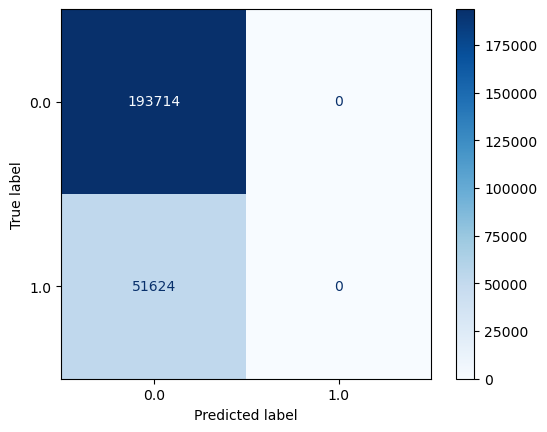

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, ConfusionMatrixDisplay

# Apply a lambda function to the "target" column to create binary predicted values
# This will set each value to 1 if it's 1, and 0 otherwise
predicted_values = y_pred['target'].apply(lambda x: 1 if x == 1 else 0)

# Extract the known labels (actual target values) from the first column of the test dataset
known_labels = df_test.iloc[:, 0]

# Calculate accuracy, precision, recall, and ROC AUC score
accuracy = accuracy_score(known_labels, predicted_values)
precision = precision_score(known_labels, predicted_values)
recall = recall_score(known_labels, predicted_values)
roc_auc = roc_auc_score(known_labels, predicted_values)

# Calculate and display the confusion matrix
conf_matrix = confusion_matrix(known_labels, predicted_values)
print("Confusion Matrix:")
print(conf_matrix)

# Print the calculated metrics
print("\nModel Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Plotting the confusion matrix with a custom color map
ConfusionMatrixDisplay.from_predictions(known_labels, predicted_values, cmap='Blues')


# XGBoost V1

### 1. Import libraries

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import boto3
import sagemaker
from sagemaker import image_uris
from sagemaker.xgboost.estimator import XGBoost


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


### 2. Load the dataset and understanding the data

In [ ]:
# Load the dataset
df = pd.read_csv("combined_csv_v1.csv")


In [ ]:
# Check rows and columns
df.shape

(1635590, 75)

In [ ]:
# Check first 5 rows
df.head()

,target,Distance,Quarter_2,Quarter_3,Quarter_4,Month_2,Month_3,Month_4,Month_5,Month_6,...,Dest_DEN,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO,DepHourofDay_Evening,DepHourofDay_Morning,DepHourofDay_Night
0,0.0,689.0,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True
1,0.0,731.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,0.0,1199.0,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,True,False,False
3,0.0,1587.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,True,False,False
4,0.0,1587.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [ ]:
# Check all columns type
for column in df.columns:
    print(column)


target
Distance
Quarter_2
Quarter_3
Quarter_4
Month_2
Month_3
Month_4
Month_5
Month_6
Month_7
Month_8
Month_9
Month_10
Month_11
Month_12
DayofMonth_2
DayofMonth_3
DayofMonth_4
DayofMonth_5
DayofMonth_6
DayofMonth_7
DayofMonth_8
DayofMonth_9
DayofMonth_10
DayofMonth_11
DayofMonth_12
DayofMonth_13
DayofMonth_14
DayofMonth_15
DayofMonth_16
DayofMonth_17
DayofMonth_18
DayofMonth_19
DayofMonth_20
DayofMonth_21
DayofMonth_22
DayofMonth_23
DayofMonth_24
DayofMonth_25
DayofMonth_26
DayofMonth_27
DayofMonth_28
DayofMonth_29
DayofMonth_30
DayofMonth_31
DayOfWeek_2
DayOfWeek_3
DayOfWeek_4
DayOfWeek_5
DayOfWeek_6
DayOfWeek_7
Reporting_Airline_DL
Reporting_Airline_OO
Reporting_Airline_UA
Reporting_Airline_WN
Origin_CLT
Origin_DEN
Origin_DFW
Origin_IAH
Origin_LAX
Origin_ORD
Origin_PHX
Origin_SFO
Dest_CLT
Dest_DEN
Dest_DFW
Dest_IAH
Dest_LAX
Dest_ORD
Dest_PHX
Dest_SFO
DepHourofDay_Evening
DepHourofDay_Morning
DepHourofDay_Night


In [ ]:
# Convert boolean columns to 0 and 1
for col in df.columns:
    if df[col].dtype == 'bool':
        df[col] = df[col].astype(float)  # Converting True to 1 and False to 0


In [ ]:
# Check all type of columns again
for column in df.columns:
    print(f"{column}: {df[column].dtype}")



target: float64
Distance: float64
Quarter_2: float64
Quarter_3: float64
Quarter_4: float64
Month_2: float64
Month_3: float64
Month_4: float64
Month_5: float64
Month_6: float64
Month_7: float64
Month_8: float64
Month_9: float64
Month_10: float64
Month_11: float64
Month_12: float64
DayofMonth_2: float64
DayofMonth_3: float64
DayofMonth_4: float64
DayofMonth_5: float64
DayofMonth_6: float64
DayofMonth_7: float64
DayofMonth_8: float64
DayofMonth_9: float64
DayofMonth_10: float64
DayofMonth_11: float64
DayofMonth_12: float64
DayofMonth_13: float64
DayofMonth_14: float64
DayofMonth_15: float64
DayofMonth_16: float64
DayofMonth_17: float64
DayofMonth_18: float64
DayofMonth_19: float64
DayofMonth_20: float64
DayofMonth_21: float64
DayofMonth_22: float64
DayofMonth_23: float64
DayofMonth_24: float64
DayofMonth_25: float64
DayofMonth_26: float64
DayofMonth_27: float64
DayofMonth_28: float64
DayofMonth_29: float64
DayofMonth_30: float64
DayofMonth_31: float64
DayOfWeek_2: float64
DayOfWeek_3: flo

### 3. Split the data into Training 70%, Validate 15% and Test 15%

In [ ]:
# Split the data into Training 70%, Validate 15% and Test 15%
train, validation = train_test_split(df, test_size=0.3)
validation, test = train_test_split(validation, test_size = 0.5)

### 4. Save Train, Validate & Test to local machine for future use

In [ ]:
# Save Train, Validate & Test to local machine for future use
train.to_csv("train_data.csv", index = False, header = False)
validation.to_csv("validation_data.csv", index = False, header = False)
test.to_csv("test_data.csv", index = False, header = False)

### 5. SageMaker and Boto3 Setup for XGBoost Model

In [ ]:
# Initialize a SageMaker session and define S3 bucket/prefix
sess = sagemaker.Session()
bucket = sess.default_bucket()
region = boto3.Session().region_name
prefix = "oncloud_flights_delay/xgboost-v1"

### 6. Uploading Training, Validation, and Test Data to S3


In [ ]:
# Upload training, validation, and test data to S3
train_path = sess.upload_data(path="train_data.csv", key_prefix=f"{prefix}/input/training")
valid_path = sess.upload_data(path="validation_data.csv", key_prefix=f"{prefix}/input/validation")
test_path = sess.upload_data(path="test_data.csv", key_prefix=f"{prefix}/input/test")

### 7. Retrieving the Container Image URI for XGBoost


In [ ]:
# Retrieve the container image URI for XGBoost
xgboost_container = image_uris.retrieve("xgboost", region, version="latest")

### 8. Initializing the XGBoost Estimator for Model Training


In [ ]:
from sagemaker.estimator import Estimator

# Set up the XGBoost estimator with necessary configurations
xgb_estimator = Estimator(xgboost_container,
                          role=sagemaker.get_execution_role(),
                          instance_count=1,
                          instance_type='ml.c5.4xlarge',
                          output_path='s3://{}/{}/output'.format(bucket,prefix))

### 9. Setting Hyperparameters for the XGBoost Model

In [ ]:
from sagemaker.xgboost.estimator import XGBoost

# Set hyperparameters for the XGBoost model
xgb_estimator.set_hyperparameters(
    objective="binary:logistic",
    num_round=20,
    early_stopping_rounds=10  # Stop if no improvement after 10 rounds
)

### 10. Defining Training and Validation Data Channels for SageMaker


In [ ]:
# Define the training and validation data channels
training_data_channel = sagemaker.TrainingInput(s3_data=train_path, content_type="text/csv")
validation_data_channel = sagemaker.TrainingInput(s3_data=valid_path, content_type="text/csv")


### 11. Starting the Training Job for the XGBoost Model


In [ ]:
# Start the training job for the XGBoost model
xgb_estimator.fit({"train": training_data_channel, "validation": validation_data_channel})


INFO:sagemaker:Creating training-job with name: xgboost-2024-11-04-10-53-26-882


2024-11-04 10:53:28 Starting - Starting the training job...
2024-11-04 10:53:43 Starting - Preparing the instances for training...
2024-11-04 10:54:30 Downloading - Downloading the training image...
2024-11-04 10:54:55 Training - Training image download completed. Training in progress...
2024-11-04 10:55:31 Uploading - Uploading generated training modelArguments: train
[2024-11-04:10:55:13:INFO] Running standalone xgboost training.
[2024-11-04:10:55:13:INFO] File size need to be processed in the node: 400.91mb. Available memory size in the node: 23487.16mb
[2024-11-04:10:55:13:INFO] Determined delimiter of CSV input is ','
[10:55:13] S3DistributionType set as FullyReplicated
[10:55:15] 1144913x74 matrix with 84723562 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2024-11-04:10:55:15:INFO] Determined delimiter of CSV input is ','
[10:55:15] S3DistributionType set as FullyReplicated
[10:55:15] 245338x74 matrix with 18155012 entries loaded from /opt/ml

### 12. Initializing the Transformer for Batch Inference


In [ ]:
# Initialize the transformer object for batch inference
transformer = xgb_estimator.transformer(
    instance_count=1,
    instance_type="ml.c5.4xlarge",
    assemble_with="Line",
    output_path=f"s3://{bucket}/{prefix}/batch_output"
)


INFO:sagemaker:Creating model with name: xgboost-2024-11-04-10-56-35-635


### 13. Preparing Test Data for Batch Inference


In [ ]:
# Load the test dataset from a CSV file
df_test = pd.read_csv('test_data.csv')

# Prepare the test batch by selecting all columns except the first one (usually the target column)
test_batch = df_test[df_test.columns[1:]]

# Save the test batch to a CSV file without index and header
test_batch.to_csv("batch_input_xgboost_v1.csv", index=False, header=False)

# Upload the saved test batch file to S3 for batch transform processing
batch_test_path = sess.upload_data(path="batch_input_xgboost_v1.csv", key_prefix=f"{prefix}/batch_input")

### 14. Starting the Batch Transform Job for Inference


In [ ]:
# Start the batch transform job using the uploaded test batch file in S3
transformer.transform(batch_test_path, content_type="text/csv", split_type="Line")

# Wait for the batch transform job to complete before proceeding
transformer.wait()


INFO:sagemaker:Creating transform job with name: xgboost-2024-11-04-10-56-48-956


............................Arguments: serve
[2024-11-04 11:01:25 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2024-11-04 11:01:25 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2024-11-04 11:01:25 +0000] [1] [INFO] Using worker: gevent
Arguments: serve
[2024-11-04 11:01:25 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2024-11-04 11:01:25 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2024-11-04 11:01:25 +0000] [1] [INFO] Using worker: gevent
[2024-11-04 11:01:25 +0000] [27] [INFO] Booting worker with pid: 27
/opt/amazon/lib/python3.7/site-packages/gunicorn/workers/ggevent.py:65: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour on Python 3.7. Please monkey-patch earlier. See https://github.com/gevent/gevent/issues/1016. Modules that had direct imports (NOT patched): ['urllib3.util (/opt/amazon/lib/python3.7/site-packages/urllib3/util/_

### 15. Starting the Batch Transform Job for Inference

In [ ]:
import io

# Start the batch transform job using the uploaded test batch file in S3
transformer.transform(batch_test_path, content_type="text/csv", split_type="Line")
transformer.wait()

INFO:sagemaker:Creating transform job with name: xgboost-2024-11-04-11-02-45-482


..................................Arguments: serve
[2024-11-04 11:08:24 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2024-11-04 11:08:24 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2024-11-04 11:08:24 +0000] [1] [INFO] Using worker: gevent
[2024-11-04 11:08:24 +0000] [27] [INFO] Booting worker with pid: 27
[2024-11-04 11:08:24 +0000] [28] [INFO] Booting worker with pid: 28
[2024-11-04 11:08:24 +0000] [29] [INFO] Booting worker with pid: 29
[2024-11-04 11:08:24 +0000] [30] [INFO] Booting worker with pid: 30
/opt/amazon/lib/python3.7/site-packages/gunicorn/workers/ggevent.py:65: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour on Python 3.7. Please monkey-patch earlier. See https://github.com/gevent/gevent/issues/1016. Modules that had direct imports (NOT patched): ['urllib3.util.ssl_ (/opt/amazon/lib/python3.7/site-packages/urllib3/util/ssl_

### 16. Evaluate the predictions with known labels

In [ ]:
import boto3

# Initialize an S3 client
s3 = boto3.client("s3")

# List objects in the specified S3 bucket with a given prefix
response = s3.list_objects_v2(Bucket=bucket, Prefix=prefix)

# Check if the 'Contents' key is in the response, indicating there are objects available
if 'Contents' in response:
    # Loop through each object in the response and print the object's key (path in the bucket)
    for obj in response['Contents']:
        print(obj['Key'])
else:
    # Print a message if no objects are found in the specified prefix
    print("No objects found in the specified prefix.")


oncloud_flights_delay/xgboost-v1/batch_input/batch_input_xgboost_v1.csv
oncloud_flights_delay/xgboost-v1/batch_output/batch_input_xgboost_v1.csv.out
oncloud_flights_delay/xgboost-v1/input/test/test_data.csv
oncloud_flights_delay/xgboost-v1/input/training/train_data.csv
oncloud_flights_delay/xgboost-v1/input/validation/validation_data.csv
oncloud_flights_delay/xgboost-v1/output/xgboost-2024-11-04-10-50-14-205/debug-output/training_job_end.ts
oncloud_flights_delay/xgboost-v1/output/xgboost-2024-11-04-10-50-14-205/output/model.tar.gz
oncloud_flights_delay/xgboost-v1/output/xgboost-2024-11-04-10-50-14-205/profiler-output/framework/training_job_end.ts
oncloud_flights_delay/xgboost-v1/output/xgboost-2024-11-04-10-50-14-205/profiler-output/system/incremental/2024110410/1730717400.algo-1.json
oncloud_flights_delay/xgboost-v1/output/xgboost-2024-11-04-10-50-14-205/profiler-output/system/incremental/2024110410/1730717460.algo-1.json
oncloud_flights_delay/xgboost-v1/output/xgboost-2024-11-04-10-5

In [ ]:
import io
import boto3

# Use the S3 client to retrieve an object from the specified bucket and key (file path) on S3
# The object represents a CSV file located in the bucket's specified folder structure
y_file = boto3.client("s3").get_object(Bucket=bucket, Key="oncloud_flights_delay/xgboost-v1/batch_input/batch_input_xgboost_v1.csv")

# Read the CSV data from the S3 object into a pandas DataFrame
# 'io.BytesIO' converts the file content from bytes to a format that can be read by pandas
# 'header=None' specifies that the CSV file does not contain a header row
# 'names=["Predicted"]' assigns a column name to the single column in the DataFrame
y_pred = pd.read_csv(io.BytesIO(y_file["Body"].read()), header=None, names=["Predicted"])


In [ ]:
# Evaluate the predictions with known labels
# Convert predicted values to binary classification (1 if >= 0.5, else 0)
predicted_values = y_pred["Predicted"].apply(lambda x: 1 if x >= 0.5 else 0)
known_labels = df_test.iloc[:, 0]

# Calculate evaluation metrics
accuracy = accuracy_score(known_labels, predicted_values)
precision = precision_score(known_labels, predicted_values)
recall = recall_score(known_labels, predicted_values)
roc_auc = roc_auc_score(known_labels, predicted_values)
conf_matrix = confusion_matrix(known_labels, predicted_values)


### 17. Print the evaluation metrics and plot the confusion matrix

Model Performance Metrics:
Accuracy: 0.7317
Precision: 0.2539
Recall: 0.1432
ROC AUC: 0.5157

Confusion Matrix:
[[172145  21674]
 [ 44143   7376]]


INFO:matplotlib.font_manager:generated new fontManager


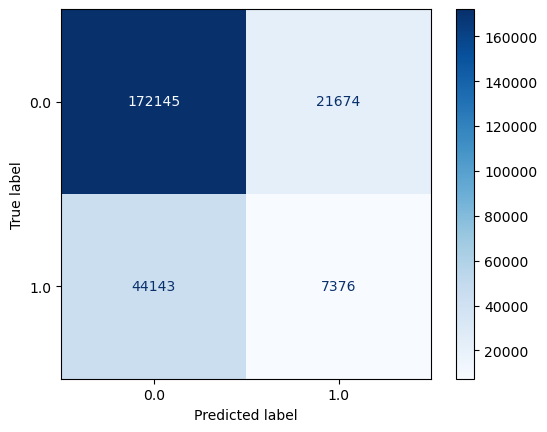

In [ ]:
# Print the evaluation metrics and plot the confusion matrix
print("Model Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Display the confusion matrix
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix with a custom color map
ConfusionMatrixDisplay.from_predictions(known_labels, predicted_values, cmap='Blues')


### 18. Plot ROC Curve

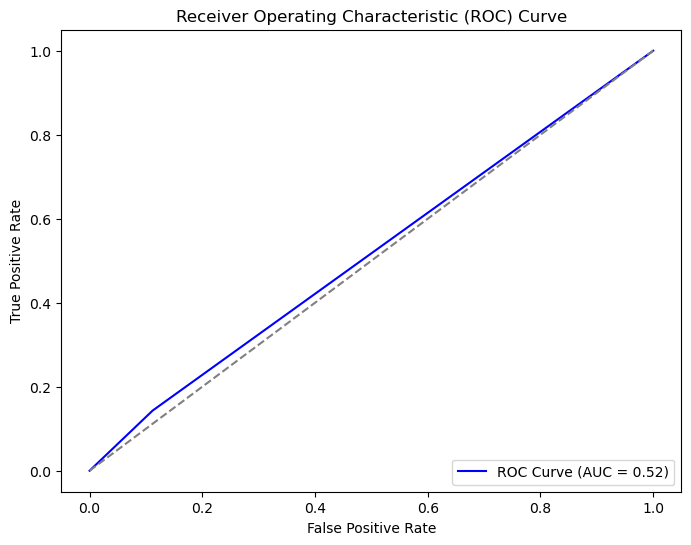

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate the ROC curve points and AUC
fpr, tpr, thresholds = roc_curve(known_labels, y_pred["Predicted"])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guessing
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


# XGBoost V2

### 1. Import libraries

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import boto3
import sagemaker
from sagemaker import image_uris
from sagemaker.xgboost.estimator import XGBoost


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


### 2. Load the dataset and understanding the data

In [ ]:
# Load the dataset
df = pd.read_csv("combined_csv_v2.csv")


In [ ]:
# Check rows and columns
df.shape

(1635590, 86)

In [ ]:
# Check first 5 rows
df.head()

,target,Distance,DepHourofDay,AWND_O,PRCP_O,TAVG_O,AWND_D,PRCP_D,TAVG_D,SNOW_O,...,Origin_SFO,Dest_CLT,Dest_DEN,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO,is_holiday_1
0,0.0,689.0,21,33,0,54.0,30,0,130.0,0.0,...,False,False,False,False,True,False,False,False,False,False
1,0.0,731.0,9,39,0,136.0,33,0,54.0,0.0,...,False,False,False,False,False,False,False,False,False,False
2,0.0,1199.0,18,33,0,54.0,77,0,68.0,0.0,...,False,False,True,False,False,False,False,False,False,False
3,0.0,1587.0,16,33,0,54.0,20,0,165.0,0.0,...,False,False,False,False,False,False,False,True,False,False
4,0.0,1587.0,7,20,0,165.0,33,0,54.0,0.0,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
# Check all columns type
for column in df.columns:
    print(column)


target
Distance
DepHourofDay
AWND_O
PRCP_O
TAVG_O
AWND_D
PRCP_D
TAVG_D
SNOW_O
SNOW_D
Year_2015
Year_2016
Year_2017
Year_2018
Quarter_2
Quarter_3
Quarter_4
Month_2
Month_3
Month_4
Month_5
Month_6
Month_7
Month_8
Month_9
Month_10
Month_11
Month_12
DayofMonth_2
DayofMonth_3
DayofMonth_4
DayofMonth_5
DayofMonth_6
DayofMonth_7
DayofMonth_8
DayofMonth_9
DayofMonth_10
DayofMonth_11
DayofMonth_12
DayofMonth_13
DayofMonth_14
DayofMonth_15
DayofMonth_16
DayofMonth_17
DayofMonth_18
DayofMonth_19
DayofMonth_20
DayofMonth_21
DayofMonth_22
DayofMonth_23
DayofMonth_24
DayofMonth_25
DayofMonth_26
DayofMonth_27
DayofMonth_28
DayofMonth_29
DayofMonth_30
DayofMonth_31
DayOfWeek_2
DayOfWeek_3
DayOfWeek_4
DayOfWeek_5
DayOfWeek_6
DayOfWeek_7
Reporting_Airline_DL
Reporting_Airline_OO
Reporting_Airline_UA
Reporting_Airline_WN
Origin_CLT
Origin_DEN
Origin_DFW
Origin_IAH
Origin_LAX
Origin_ORD
Origin_PHX
Origin_SFO
Dest_CLT
Dest_DEN
Dest_DFW
Dest_IAH
Dest_LAX
Dest_ORD
Dest_PHX
Dest_SFO
is_holiday_1


In [ ]:
# Convert boolean columns to 0 and 1
for col in df.columns:
    if df[col].dtype == 'bool':
        df[col] = df[col].astype(float)  # Converting True to 1 and False to 0


In [ ]:
# Check all type of columns again
for column in df.columns:
    print(f"{column}: {df[column].dtype}")



target: float64
Distance: float64
DepHourofDay: int64
AWND_O: int64
PRCP_O: int64
TAVG_O: float64
AWND_D: int64
PRCP_D: int64
TAVG_D: float64
SNOW_O: float64
SNOW_D: float64
Year_2015: float64
Year_2016: float64
Year_2017: float64
Year_2018: float64
Quarter_2: float64
Quarter_3: float64
Quarter_4: float64
Month_2: float64
Month_3: float64
Month_4: float64
Month_5: float64
Month_6: float64
Month_7: float64
Month_8: float64
Month_9: float64
Month_10: float64
Month_11: float64
Month_12: float64
DayofMonth_2: float64
DayofMonth_3: float64
DayofMonth_4: float64
DayofMonth_5: float64
DayofMonth_6: float64
DayofMonth_7: float64
DayofMonth_8: float64
DayofMonth_9: float64
DayofMonth_10: float64
DayofMonth_11: float64
DayofMonth_12: float64
DayofMonth_13: float64
DayofMonth_14: float64
DayofMonth_15: float64
DayofMonth_16: float64
DayofMonth_17: float64
DayofMonth_18: float64
DayofMonth_19: float64
DayofMonth_20: float64
DayofMonth_21: float64
DayofMonth_22: float64
DayofMonth_23: float64
Dayof

### 3. Split the data into Training 70%, Validate 15% and Test 15%

In [ ]:
# Split the data into Training 70%, Validate 15% and Test 15%
train, validation = train_test_split(df, test_size=0.3)
validation, test = train_test_split(validation, test_size = 0.5)

### 4. Save Train, Validate & Test to local machine for future use

In [ ]:
# Save Train, Validate & Test to local machine for future use
train.to_csv("train_data.csv", index = False, header = False)
validation.to_csv("validation_data.csv", index = False, header = False)
test.to_csv("test_data.csv", index = False, header = False)

### 5. SageMaker and Boto3 Setup for XGBoost Model

In [ ]:
# Initialize a SageMaker session and define S3 bucket/prefix
sess = sagemaker.Session()
bucket = sess.default_bucket()
region = boto3.Session().region_name
prefix = "oncloud_flights_delay/xgboost-v2"

### 6. Uploading Training, Validation, and Test Data to S3


In [ ]:
# Upload training, validation, and test data to S3
train_path = sess.upload_data(path="train_data.csv", key_prefix=f"{prefix}/input/training")
valid_path = sess.upload_data(path="validation_data.csv", key_prefix=f"{prefix}/input/validation")
test_path = sess.upload_data(path="test_data.csv", key_prefix=f"{prefix}/input/test")

### 7. Retrieving the Container Image URI for XGBoost


In [ ]:
# Retrieve the container image URI for XGBoost
xgboost_container = image_uris.retrieve("xgboost", region, version="latest")

### 8. Initializing the XGBoost Estimator for Model Training


In [ ]:
from sagemaker.estimator import Estimator

# Set up the XGBoost estimator with necessary configurations
xgb_estimator = Estimator(xgboost_container,
                          role=sagemaker.get_execution_role(),
                          instance_count=1,
                          instance_type='ml.c5.4xlarge',
                          output_path='s3://{}/{}/output'.format(bucket,prefix))

### 9. Setting Hyperparameters for the XGBoost Model

In [ ]:
from sagemaker.xgboost.estimator import XGBoost

# Set hyperparameters for the XGBoost model
xgb_estimator.set_hyperparameters(
    objective="binary:logistic",
    num_round=20,
    early_stopping_rounds=10  # Stop if no improvement after 10 rounds
)

### 10. Defining Training and Validation Data Channels for SageMaker


In [ ]:
# Define the training and validation data channels
training_data_channel = sagemaker.TrainingInput(s3_data=train_path, content_type="text/csv")
validation_data_channel = sagemaker.TrainingInput(s3_data=valid_path, content_type="text/csv")


### 11. Starting the Training Job for the XGBoost Model


In [ ]:
# Start the training job for the XGBoost model
xgb_estimator.fit({"train": training_data_channel, "validation": validation_data_channel})


INFO:sagemaker:Creating training-job with name: xgboost-2024-11-04-11-20-29-738


2024-11-04 11:20:31 Starting - Starting the training job...
2024-11-04 11:20:46 Starting - Preparing the instances for training...
2024-11-04 11:21:14 Downloading - Downloading input data...
2024-11-04 11:22:04 Training - Training image download completed. Training in progress....Arguments: train
[2024-11-04:11:22:22:INFO] Running standalone xgboost training.
[2024-11-04:11:22:22:INFO] File size need to be processed in the node: 455.25mb. Available memory size in the node: 23496.22mb
[2024-11-04:11:22:22:INFO] Determined delimiter of CSV input is ','
[11:22:22] S3DistributionType set as FullyReplicated
[11:22:23] 1144913x85 matrix with 97317605 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2024-11-04:11:22:23:INFO] Determined delimiter of CSV input is ','
[11:22:23] S3DistributionType set as FullyReplicated
[11:22:24] 245338x85 matrix with 20853730 entries loaded from /opt/ml/input/data/validation?format=csv&label_column=0&delimiter=,
[11:22:25] sr

### 12. Initializing the Transformer for Batch Inference


In [ ]:
# Initialize the transformer object for batch inference
transformer = xgb_estimator.transformer(
    instance_count=1,
    instance_type="ml.c5.4xlarge",
    assemble_with="Line",
    output_path=f"s3://{bucket}/{prefix}/batch_output"
)


INFO:sagemaker:Creating model with name: xgboost-2024-11-04-11-23-17-954


### 13. Preparing Test Data for Batch Inference


In [ ]:
# Load the test dataset from a CSV file
df_test = pd.read_csv('test_data.csv')

# Prepare the test batch by selecting all columns except the first one (usually the target column)
test_batch = df_test[df_test.columns[1:]]

# Save the test batch to a CSV file without index and header
test_batch.to_csv("batch_input_xgboost_v2.csv", index=False, header=False)

# Upload the saved test batch file to S3 for batch transform processing
batch_test_path = sess.upload_data(path="batch_input_xgboost_v2.csv", key_prefix=f"{prefix}/batch_input")

### 14. Starting the Batch Transform Job for Inference


In [ ]:
# Start the batch transform job using the uploaded test batch file in S3
transformer.transform(batch_test_path, content_type="text/csv", split_type="Line")

# Wait for the batch transform job to complete before proceeding
transformer.wait()


INFO:sagemaker:Creating transform job with name: xgboost-2024-11-04-11-23-27-449


................................Arguments: serve
Arguments: serve
[2024-11-04 11:28:45 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2024-11-04 11:28:45 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2024-11-04 11:28:45 +0000] [1] [INFO] Using worker: gevent
[2024-11-04 11:28:45 +0000] [28] [INFO] Booting worker with pid: 28
[2024-11-04 11:28:45 +0000] [29] [INFO] Booting worker with pid: 29
/opt/amazon/lib/python3.7/site-packages/gunicorn/workers/ggevent.py:65: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour on Python 3.7. Please monkey-patch earlier. See https://github.com/gevent/gevent/issues/1016. Modules that had direct imports (NOT patched): ['urllib3.util.ssl_ (/opt/amazon/lib/python3.7/site-packages/urllib3/util/ssl_.py)', 'urllib3.util (/opt/amazon/lib/python3.7/site-packages/urllib3/util/__init__.py)']. 
  monkey.patch_all(subprocess

### 15. Starting the Batch Transform Job for Inference

In [ ]:
import io

# Start the batch transform job using the uploaded test batch file in S3
transformer.transform(batch_test_path, content_type="text/csv", split_type="Line")
transformer.wait()

INFO:sagemaker:Creating transform job with name: xgboost-2024-11-04-11-29-31-139


.................................
2024-11-04T11:35:05.498:[sagemaker logs]: MaxConcurrentTransforms=16, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD
Arguments: serve
[2024-11-04 11:35:02 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2024-11-04 11:35:02 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2024-11-04 11:35:02 +0000] [1] [INFO] Using worker: gevent
[2024-11-04 11:35:02 +0000] [27] [INFO] Booting worker with pid: 27
[2024-11-04 11:35:02 +0000] [28] [INFO] Booting worker with pid: 28
[2024-11-04 11:35:02 +0000] [29] [INFO] Booting worker with pid: 29
/opt/amazon/lib/python3.7/site-packages/gunicorn/workers/ggevent.py:65: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour on Python 3.7. Please monkey-patch earlier. See https://github.com/gevent/gevent/issues/1016. Modules that had direct imports (NOT patched): ['urllib3.util (/opt/amazon/lib

### 16. Evaluate the predictions with known labels

In [ ]:
import boto3

# Initialize an S3 client
s3 = boto3.client("s3")

# List objects in the specified S3 bucket with a given prefix
response = s3.list_objects_v2(Bucket=bucket, Prefix=prefix)

# Check if the 'Contents' key is in the response, indicating there are objects available
if 'Contents' in response:
    # Loop through each object in the response and print the object's key (path in the bucket)
    for obj in response['Contents']:
        print(obj['Key'])
else:
    # Print a message if no objects are found in the specified prefix
    print("No objects found in the specified prefix.")


oncloud_flights_delay/xgboost-v2/batch_input/batch_input_xgboost_v2.csv
oncloud_flights_delay/xgboost-v2/batch_output/batch_input_xgboost_v2.csv.out
oncloud_flights_delay/xgboost-v2/input/test/test_data.csv
oncloud_flights_delay/xgboost-v2/input/training/train_data.csv
oncloud_flights_delay/xgboost-v2/input/validation/validation_data.csv
oncloud_flights_delay/xgboost-v2/output/xgboost-2024-11-04-11-20-29-738/debug-output/training_job_end.ts
oncloud_flights_delay/xgboost-v2/output/xgboost-2024-11-04-11-20-29-738/output/model.tar.gz
oncloud_flights_delay/xgboost-v2/output/xgboost-2024-11-04-11-20-29-738/profiler-output/framework/training_job_end.ts
oncloud_flights_delay/xgboost-v2/output/xgboost-2024-11-04-11-20-29-738/profiler-output/system/incremental/2024110411/1730719260.algo-1.json
oncloud_flights_delay/xgboost-v2/output/xgboost-2024-11-04-11-20-29-738/profiler-output/system/incremental/2024110411/1730719320.algo-1.json
oncloud_flights_delay/xgboost-v2/output/xgboost-2024-11-04-11-2

In [ ]:
import io
import boto3

# Retrieve the specified CSV file from S3 as an object using the S3 client
y_file = boto3.client("s3").get_object(Bucket=bucket, Key="oncloud_flights_delay/xgboost-v2/batch_input/batch_input_xgboost_v2.csv")

# Load the CSV data from the S3 object into a pandas DataFrame
# 'header=None' specifies no header row in the CSV, and 'names' assigns column names
y_pred = pd.read_csv(io.BytesIO(y_file["Body"].read()), header=None, names=["Predicted"])

# Add a new column 'actual' based on the 'Predicted' column, applying a threshold
# If 'Predicted' is greater than 0.5, 'actual' is set to 1; otherwise, it is set to 0
y_pred["actual"] = y_pred["Predicted"].apply(lambda x: 1 if x > 0.5 else 0)


In [ ]:
# Evaluate the predictions with known labels
# Convert predicted values to binary classification (1 if >= 0.5, else 0)
predicted_values = y_pred["Predicted"].apply(lambda x: 1 if x >= 0.5 else 0)
known_labels = df_test.iloc[:, 0]

# Calculate evaluation metrics
accuracy = accuracy_score(known_labels, predicted_values)
precision = precision_score(known_labels, predicted_values)
recall = recall_score(known_labels, predicted_values)
roc_auc = roc_auc_score(known_labels, predicted_values)
conf_matrix = confusion_matrix(known_labels, predicted_values)


### 17. Print the evaluation metrics and plot the confusion matrix

Model Performance Metrics:
Accuracy: 0.7728
Precision: 0.2009
Recall: 0.0258
ROC AUC: 0.4992

Confusion Matrix:
[[188255   5310]
 [ 50438   1335]]


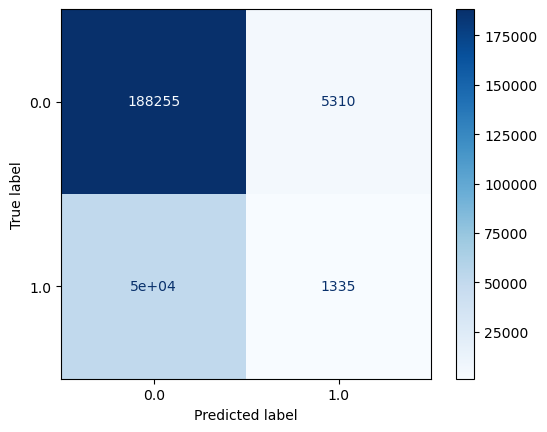

In [ ]:
# Print the evaluation metrics and plot the confusion matrix
print("Model Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Display the confusion matrix
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix with a custom color map
ConfusionMatrixDisplay.from_predictions(known_labels, predicted_values, cmap='Blues')


### 18. Plot ROC Curve

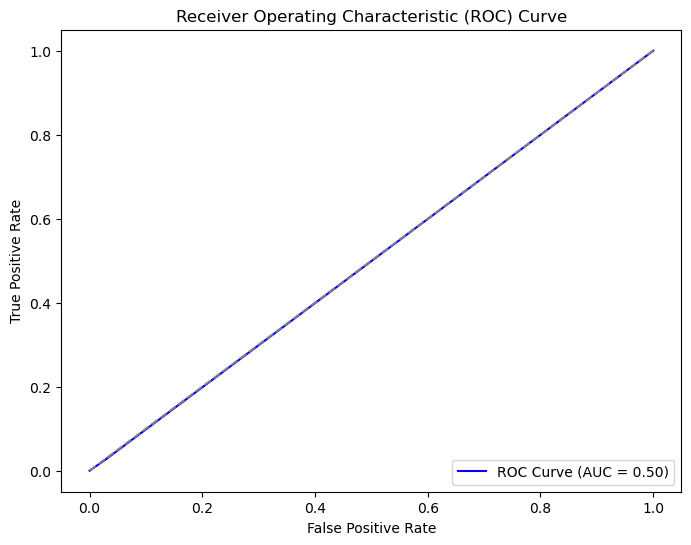

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate the ROC curve points and AUC
fpr, tpr, thresholds = roc_curve(known_labels, y_pred["Predicted"])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guessing
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


### 1. Import libraries

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import boto3
import sagemaker
from sagemaker import image_uris
from sagemaker.xgboost.estimator import XGBoost


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


### 2. Load the dataset and understanding the data

In [ ]:
# Load the dataset
df = pd.read_csv("combined_csv_v1.csv")


In [ ]:
# Check rows and columns
df.shape

(1635590, 75)

In [ ]:
# Check first 5 rows
df.head()

,target,Distance,Quarter_2,Quarter_3,Quarter_4,Month_2,Month_3,Month_4,Month_5,Month_6,...,Dest_DEN,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO,DepHourofDay_Evening,DepHourofDay_Morning,DepHourofDay_Night
0,0.0,689.0,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True
1,0.0,731.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,0.0,1199.0,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,True,False,False
3,0.0,1587.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,True,False,False
4,0.0,1587.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [ ]:
# Check all columns type
for column in df.columns:
    print(column)


target
Distance
Quarter_2
Quarter_3
Quarter_4
Month_2
Month_3
Month_4
Month_5
Month_6
Month_7
Month_8
Month_9
Month_10
Month_11
Month_12
DayofMonth_2
DayofMonth_3
DayofMonth_4
DayofMonth_5
DayofMonth_6
DayofMonth_7
DayofMonth_8
DayofMonth_9
DayofMonth_10
DayofMonth_11
DayofMonth_12
DayofMonth_13
DayofMonth_14
DayofMonth_15
DayofMonth_16
DayofMonth_17
DayofMonth_18
DayofMonth_19
DayofMonth_20
DayofMonth_21
DayofMonth_22
DayofMonth_23
DayofMonth_24
DayofMonth_25
DayofMonth_26
DayofMonth_27
DayofMonth_28
DayofMonth_29
DayofMonth_30
DayofMonth_31
DayOfWeek_2
DayOfWeek_3
DayOfWeek_4
DayOfWeek_5
DayOfWeek_6
DayOfWeek_7
Reporting_Airline_DL
Reporting_Airline_OO
Reporting_Airline_UA
Reporting_Airline_WN
Origin_CLT
Origin_DEN
Origin_DFW
Origin_IAH
Origin_LAX
Origin_ORD
Origin_PHX
Origin_SFO
Dest_CLT
Dest_DEN
Dest_DFW
Dest_IAH
Dest_LAX
Dest_ORD
Dest_PHX
Dest_SFO
DepHourofDay_Evening
DepHourofDay_Morning
DepHourofDay_Night


In [ ]:
# Convert boolean columns to 0 and 1
for col in df.columns:
    if df[col].dtype == 'bool':
        df[col] = df[col].astype(float)  # Converting True to 1 and False to 0


In [ ]:
# Check all type of columns again
for column in df.columns:
    print(f"{column}: {df[column].dtype}")



target: float64
Distance: float64
Quarter_2: float64
Quarter_3: float64
Quarter_4: float64
Month_2: float64
Month_3: float64
Month_4: float64
Month_5: float64
Month_6: float64
Month_7: float64
Month_8: float64
Month_9: float64
Month_10: float64
Month_11: float64
Month_12: float64
DayofMonth_2: float64
DayofMonth_3: float64
DayofMonth_4: float64
DayofMonth_5: float64
DayofMonth_6: float64
DayofMonth_7: float64
DayofMonth_8: float64
DayofMonth_9: float64
DayofMonth_10: float64
DayofMonth_11: float64
DayofMonth_12: float64
DayofMonth_13: float64
DayofMonth_14: float64
DayofMonth_15: float64
DayofMonth_16: float64
DayofMonth_17: float64
DayofMonth_18: float64
DayofMonth_19: float64
DayofMonth_20: float64
DayofMonth_21: float64
DayofMonth_22: float64
DayofMonth_23: float64
DayofMonth_24: float64
DayofMonth_25: float64
DayofMonth_26: float64
DayofMonth_27: float64
DayofMonth_28: float64
DayofMonth_29: float64
DayofMonth_30: float64
DayofMonth_31: float64
DayOfWeek_2: float64
DayOfWeek_3: flo

### 3. Split the data into Training 70%, Validate 15% and Test 15%

In [ ]:
# Split the data into Training 70%, Validate 15% and Test 15%
train, validation = train_test_split(df, test_size=0.3)
validation, test = train_test_split(validation, test_size = 0.5)

### 4. Save Train, Validate & Test to local machine for future use

In [ ]:
# Save Train, Validate & Test to local machine for future use
train.to_csv("train_data.csv", index = False, header = False)
validation.to_csv("validation_data.csv", index = False, header = False)
test.to_csv("test_data.csv", index = False, header = False)

### 5. SageMaker and Boto3 Setup for XGBoost Model

In [ ]:
# Initialize a SageMaker session and define S3 bucket/prefix
sess = sagemaker.Session()
bucket = sess.default_bucket()
region = boto3.Session().region_name
prefix = "oncloud_flights_delay/xgboost-v1"

### 6. Uploading Training, Validation, and Test Data to S3


In [ ]:
# Upload training, validation, and test data to S3
train_path = sess.upload_data(path="train_data.csv", key_prefix=f"{prefix}/input/training")
valid_path = sess.upload_data(path="validation_data.csv", key_prefix=f"{prefix}/input/validation")
test_path = sess.upload_data(path="test_data.csv", key_prefix=f"{prefix}/input/test")

### 7. Retrieving the Container Image URI for XGBoost


In [ ]:
# Retrieve the container image URI for XGBoost
xgboost_container = image_uris.retrieve("xgboost", region, version="latest")

### 8. Initializing the XGBoost Estimator for Model Training


In [ ]:
from sagemaker.estimator import Estimator

# Set up the XGBoost estimator with necessary configurations
xgb_estimator = Estimator(xgboost_container,
                          role=sagemaker.get_execution_role(),
                          instance_count=1,
                          instance_type='ml.c5.4xlarge',
                          output_path='s3://{}/{}/output'.format(bucket,prefix))

### 9. Setting Hyperparameters for the XGBoost Model

In [ ]:
from sagemaker.xgboost.estimator import XGBoost

# Set hyperparameters for the XGBoost model
xgb_estimator.set_hyperparameters(
    objective="binary:logistic",
    num_round=20,
    early_stopping_rounds=10  # Stop if no improvement after 10 rounds
)

### 10. Defining Training and Validation Data Channels for SageMaker


In [ ]:
# Define the training and validation data channels
training_data_channel = sagemaker.TrainingInput(s3_data=train_path, content_type="text/csv")
validation_data_channel = sagemaker.TrainingInput(s3_data=valid_path, content_type="text/csv")


### 11. Starting the Training Job for the XGBoost Model


In [ ]:
# Start the training job for the XGBoost model
xgb_estimator.fit({"train": training_data_channel, "validation": validation_data_channel})


INFO:sagemaker:Creating training-job with name: xgboost-2024-11-04-10-53-26-882


2024-11-04 10:53:28 Starting - Starting the training job...
2024-11-04 10:53:43 Starting - Preparing the instances for training...
2024-11-04 10:54:30 Downloading - Downloading the training image...
2024-11-04 10:54:55 Training - Training image download completed. Training in progress...
2024-11-04 10:55:31 Uploading - Uploading generated training modelArguments: train
[2024-11-04:10:55:13:INFO] Running standalone xgboost training.
[2024-11-04:10:55:13:INFO] File size need to be processed in the node: 400.91mb. Available memory size in the node: 23487.16mb
[2024-11-04:10:55:13:INFO] Determined delimiter of CSV input is ','
[10:55:13] S3DistributionType set as FullyReplicated
[10:55:15] 1144913x74 matrix with 84723562 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2024-11-04:10:55:15:INFO] Determined delimiter of CSV input is ','
[10:55:15] S3DistributionType set as FullyReplicated
[10:55:15] 245338x74 matrix with 18155012 entries loaded from /opt/ml

### 12. Initializing the Transformer for Batch Inference


In [ ]:
# Initialize the transformer object for batch inference
transformer = xgb_estimator.transformer(
    instance_count=1,
    instance_type="ml.c5.4xlarge",
    assemble_with="Line",
    output_path=f"s3://{bucket}/{prefix}/batch_output"
)


INFO:sagemaker:Creating model with name: xgboost-2024-11-04-10-56-35-635


### 13. Preparing Test Data for Batch Inference


In [ ]:
# Load the test dataset from a CSV file
df_test = pd.read_csv('test_data.csv')

# Prepare the test batch by selecting all columns except the first one (usually the target column)
test_batch = df_test[df_test.columns[1:]]

# Save the test batch to a CSV file without index and header
test_batch.to_csv("batch_input_xgboost_v1.csv", index=False, header=False)

# Upload the saved test batch file to S3 for batch transform processing
batch_test_path = sess.upload_data(path="batch_input_xgboost_v1.csv", key_prefix=f"{prefix}/batch_input")

### 14. Starting the Batch Transform Job for Inference


In [ ]:
# Start the batch transform job using the uploaded test batch file in S3
transformer.transform(batch_test_path, content_type="text/csv", split_type="Line")

# Wait for the batch transform job to complete before proceeding
transformer.wait()


INFO:sagemaker:Creating transform job with name: xgboost-2024-11-04-10-56-48-956


............................Arguments: serve
[2024-11-04 11:01:25 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2024-11-04 11:01:25 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2024-11-04 11:01:25 +0000] [1] [INFO] Using worker: gevent
Arguments: serve
[2024-11-04 11:01:25 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2024-11-04 11:01:25 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2024-11-04 11:01:25 +0000] [1] [INFO] Using worker: gevent
[2024-11-04 11:01:25 +0000] [27] [INFO] Booting worker with pid: 27
/opt/amazon/lib/python3.7/site-packages/gunicorn/workers/ggevent.py:65: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour on Python 3.7. Please monkey-patch earlier. See https://github.com/gevent/gevent/issues/1016. Modules that had direct imports (NOT patched): ['urllib3.util (/opt/amazon/lib/python3.7/site-packages/urllib3/util/_

### 15. Starting the Batch Transform Job for Inference

In [ ]:
import io

# Start the batch transform job using the uploaded test batch file in S3
transformer.transform(batch_test_path, content_type="text/csv", split_type="Line")
transformer.wait()

INFO:sagemaker:Creating transform job with name: xgboost-2024-11-04-11-02-45-482


..................................Arguments: serve
[2024-11-04 11:08:24 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2024-11-04 11:08:24 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2024-11-04 11:08:24 +0000] [1] [INFO] Using worker: gevent
[2024-11-04 11:08:24 +0000] [27] [INFO] Booting worker with pid: 27
[2024-11-04 11:08:24 +0000] [28] [INFO] Booting worker with pid: 28
[2024-11-04 11:08:24 +0000] [29] [INFO] Booting worker with pid: 29
[2024-11-04 11:08:24 +0000] [30] [INFO] Booting worker with pid: 30
/opt/amazon/lib/python3.7/site-packages/gunicorn/workers/ggevent.py:65: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour on Python 3.7. Please monkey-patch earlier. See https://github.com/gevent/gevent/issues/1016. Modules that had direct imports (NOT patched): ['urllib3.util.ssl_ (/opt/amazon/lib/python3.7/site-packages/urllib3/util/ssl_

### 16. Evaluate the predictions with known labels

In [ ]:
import boto3

# Initialize an S3 client
s3 = boto3.client("s3")

# List objects in the specified S3 bucket with a given prefix
response = s3.list_objects_v2(Bucket=bucket, Prefix=prefix)

# Check if the 'Contents' key is in the response, indicating there are objects available
if 'Contents' in response:
    # Loop through each object in the response and print the object's key (path in the bucket)
    for obj in response['Contents']:
        print(obj['Key'])
else:
    # Print a message if no objects are found in the specified prefix
    print("No objects found in the specified prefix.")


oncloud_flights_delay/xgboost-v1/batch_input/batch_input_xgboost_v1.csv
oncloud_flights_delay/xgboost-v1/batch_output/batch_input_xgboost_v1.csv.out
oncloud_flights_delay/xgboost-v1/input/test/test_data.csv
oncloud_flights_delay/xgboost-v1/input/training/train_data.csv
oncloud_flights_delay/xgboost-v1/input/validation/validation_data.csv
oncloud_flights_delay/xgboost-v1/output/xgboost-2024-11-04-10-50-14-205/debug-output/training_job_end.ts
oncloud_flights_delay/xgboost-v1/output/xgboost-2024-11-04-10-50-14-205/output/model.tar.gz
oncloud_flights_delay/xgboost-v1/output/xgboost-2024-11-04-10-50-14-205/profiler-output/framework/training_job_end.ts
oncloud_flights_delay/xgboost-v1/output/xgboost-2024-11-04-10-50-14-205/profiler-output/system/incremental/2024110410/1730717400.algo-1.json
oncloud_flights_delay/xgboost-v1/output/xgboost-2024-11-04-10-50-14-205/profiler-output/system/incremental/2024110410/1730717460.algo-1.json
oncloud_flights_delay/xgboost-v1/output/xgboost-2024-11-04-10-5

In [ ]:
import io
import boto3

# Use the S3 client to retrieve an object from the specified bucket and key (file path) on S3
# The object represents a CSV file located in the bucket's specified folder structure
y_file = boto3.client("s3").get_object(Bucket=bucket, Key="oncloud_flights_delay/xgboost-v1/batch_input/batch_input_xgboost_v1.csv")

# Read the CSV data from the S3 object into a pandas DataFrame
# 'io.BytesIO' converts the file content from bytes to a format that can be read by pandas
# 'header=None' specifies that the CSV file does not contain a header row
# 'names=["Predicted"]' assigns a column name to the single column in the DataFrame
y_pred = pd.read_csv(io.BytesIO(y_file["Body"].read()), header=None, names=["Predicted"])


In [ ]:
# Evaluate the predictions with known labels
# Convert predicted values to binary classification (1 if >= 0.5, else 0)
predicted_values = y_pred["Predicted"].apply(lambda x: 1 if x >= 0.5 else 0)
known_labels = df_test.iloc[:, 0]

# Calculate evaluation metrics
accuracy = accuracy_score(known_labels, predicted_values)
precision = precision_score(known_labels, predicted_values)
recall = recall_score(known_labels, predicted_values)
roc_auc = roc_auc_score(known_labels, predicted_values)
conf_matrix = confusion_matrix(known_labels, predicted_values)


### 17. Print the evaluation metrics and plot the confusion matrix

Model Performance Metrics:
Accuracy: 0.7317
Precision: 0.2539
Recall: 0.1432
ROC AUC: 0.5157

Confusion Matrix:
[[172145  21674]
 [ 44143   7376]]


INFO:matplotlib.font_manager:generated new fontManager


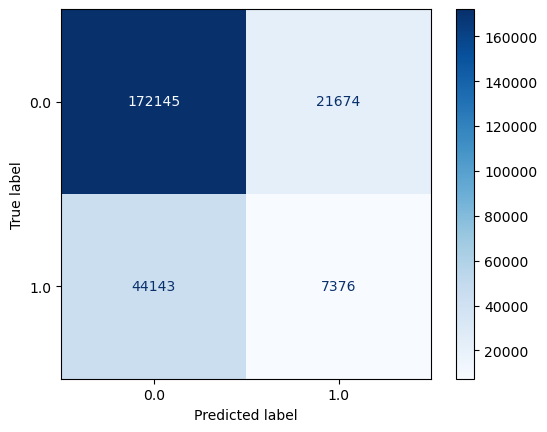

In [ ]:
# Print the evaluation metrics and plot the confusion matrix
print("Model Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Display the confusion matrix
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix with a custom color map
ConfusionMatrixDisplay.from_predictions(known_labels, predicted_values, cmap='Blues')


### 18. Plot ROC Curve

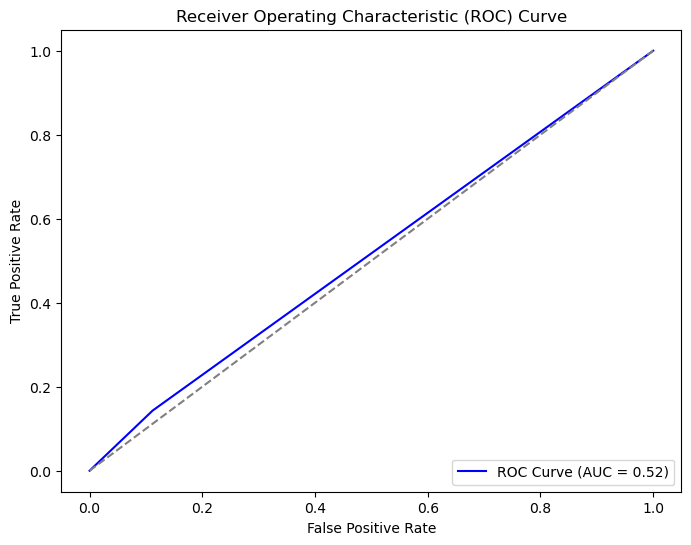

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate the ROC curve points and AUC
fpr, tpr, thresholds = roc_curve(known_labels, y_pred["Predicted"])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guessing
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


# Conclusion

The model evaluation results reveal key challenges in accurately predicting the target variable, particularly for the Linear Learner models. Both versions of the Linear Learner display high accuracy (around 79%); however, this accuracy does not translate into effective prediction of the positive class, as seen with a precision and recall of 0.0 and an ROC AUC of 0.5. This likely reflects an inability to differentiate the two classes, with the model defaulting to the majority class and thus inflating the accuracy due to class imbalance.

The XGBoost models show some improvement in capturing the positive class, with XGBoost v1 achieving a precision of 0.2539, recall of 0.1432, and an ROC AUC of 0.5157, suggesting slight class separation. XGBoost v2, while it achieves a higher accuracy of 77.28%, sees a drop in recall (0.0258) and precision (0.2009), indicating ongoing struggles in balancing predictions between classes.

In summary, although the XGBoost models marginally improve minority class prediction over the Linear Learner models, both require further tuning. To enhance precision, recall, and ROC AUC, consider applying class imbalance handling techniques (e.g., SMOTE or undersampling the majority class), experimenting with different hyperparameters, or even testing alternative algorithms better suited for imbalanced data. These steps could improve the model’s ability to capture positive cases, leading to more balanced and meaningful performance metrics.

    - Model	                Accuracy	Precision   Recall	ROC AUC
    - Linear Learner v1     0.7907	        0.0000	    0.0000	0.5000
    - Linear Learner v2	0.7896	        0.0000	    0.0000	0.5000
    - XGBoost v1	        0.7317	        0.2539	    0.1432	0.5157
    - XGBoost v2	        0.7728	        0.2009	    0.0258	0.4992